In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import copy
%matplotlib inline

In [2]:
manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  4445


In [3]:
coco_dataset = dset.CocoCaptions(
    root='inpainting/train2014',
    annFile='inpainting/annotations/captions_train2014.json',
    transform=transforms.ToTensor()
)

loading annotations into memory...
Done (t=1.30s)
creating index...
index created!


In [4]:
class DataIterator(object):
    """Data Iterator for COCO."""

    def __init__(
        self,
        train_path='inpainting/cocorealtrain2014',
        dev_path='inpainting/cocorealval2014',
        train_annotation_path='inpainting/annotations/captions_train2014.json',
        dev_annotation_path='inpainting/annotations/captions_val2014.json',
    ):
        """Initialize params."""
        self.train_path = train_path
        self.train_annotation_path = train_annotation_path
        self.dev_path = dev_path
        self.dev_annotation_path = dev_annotation_path
        print('Processing data ...')
        self._get_real_and_fake_images()

    def _get_real_and_fake_images(self):
        """Get real and fake images from path."""
    
        self.train_dataset = dset.CocoCaptions(
            root=self.train_path,
            annFile=self.train_annotation_path,
            transform=transforms.Compose([
                transforms.CenterCrop(256),
                transforms.ToTensor()])
        )
        self.valid_dataset = dset.CocoCaptions(
            root=self.dev_path, 
            annFile=self.dev_annotation_path,
            transform=transforms.Compose([
                transforms.CenterCrop(256),
                transforms.ToTensor()])
        )
        
        print ('Cropping to a square images ...')         
        print('Populating training images & captions ...')
        train_images = []
        train_captions = []
        
        # There appears to be one image missing for some weird reason.
        try:
            for img, captions in self.train_dataset:
                train_images.append(img)
                train_captions.append(captions)
        except IOError:
            pass
        
        train_images = torch.stack(train_images)
        
        print('Populating validation images ...')
        valid_images = torch.stack([x[0] for x in self.valid_dataset])
        valid_captions = [x[1] for x in self.valid_dataset]        
        
        
        print('Cropping 32x32 patch for training images ...')
        noisy_train_images = copy.deepcopy(train_images.numpy())
        noisy_train_images[:, :, 16:48, 16:48] = 0
        noisy_train_images = torch.from_numpy(noisy_train_images)

        print('Cropping 32x32 patch for validation images ...')
        noisy_valid_images = copy.deepcopy(valid_images.numpy())
        noisy_valid_images[:, :, 16:48, 16:48] = 0
        noisy_valid_images = torch.from_numpy(noisy_valid_images)
        
        self.train_images = train_images
        self.valid_images = valid_images

        self.noisy_train_images = noisy_train_images
        self.noisy_valid_images = noisy_valid_images
        
        self.num_train = len(train_images)
        self.num_valid = len(valid_images)

    def get_train_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.train_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_train_images[index: index + batch_size]).cuda()
        return real_examples, real_examples[:, :, 16:48, 16:48], fake_examples

    def get_valid_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.valid_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_valid_images[index: index + batch_size]).cuda()
        
        return real_examples, real_examples[:, :, 16:48, 16:48], fake_examples

In [5]:
iterator = DataIterator()

Processing data ...
loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
Cropping to a square images ...
Populating training images & captions ...


RuntimeError: expected a non-empty list of Tensors

(-0.5, 63.5, 63.5, -0.5)

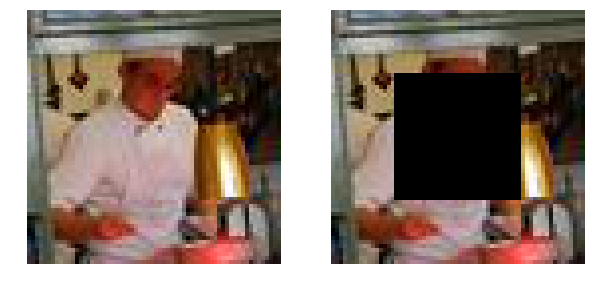

In [6]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(iterator.train_images[14].numpy().transpose(1, 2, 0))
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(iterator.noisy_train_images[14].numpy().transpose(1, 2, 0))
plt.axis('off')

In [7]:
class UNetGenerator(nn.Module):
    """Generator module."""

    def __init__(self, start_filter):
        """Initialize generator."""
        super(UNetGenerator, self).__init__()

        #################################
        ####### DOWNSAMPLER MODULE ######
        #################################

        # 3 x 64 x 64
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=start_filter, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(start_filter)

        # 16 x 32 x 32
        self.conv2 = nn.Conv2d(
            in_channels=start_filter, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 16 x 16
        self.conv3 = nn.Conv2d(
            in_channels=start_filter * 2, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(start_filter * 3)

        # 64 x 8 x 8
        self.conv4 = nn.Conv2d(
            in_channels=start_filter * 3, out_channels=start_filter * 4,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(start_filter * 4)

        #################################
        ####### UPSAMPLER MODULE ########
        #################################

        # 128 x 4 x 4
        self.tconv1 = nn.ConvTranspose2d(
            in_channels=start_filter * 4, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn1 = nn.BatchNorm2d(start_filter * 3)

        # 64 x 8 x 8
        self.tconv2 = nn.ConvTranspose2d(
            in_channels=start_filter * 3, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 16 x 16
        self.tconv3 = nn.ConvTranspose2d(
            in_channels=start_filter * 2, out_channels=start_filter,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn3 = nn.BatchNorm2d(start_filter)

        # 16 x 32 x 32
        self.tconv4 = nn.ConvTranspose2d(
            in_channels=start_filter, out_channels=3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        # Finally - 3 x 64 x 64

    def forward(self, input):
        """Propogate input through the generator."""
        # Downsampling steps.
        conv1 = F.relu(self.bn1(self.conv1(input)))
        conv2 = F.relu(self.bn2(self.conv2(conv1)))
        conv3 = F.relu(self.bn3(self.conv3(conv2)))
        conv4 = F.relu(self.bn4(self.conv4(conv3)))

        # Upsampling steps.
        tconv1 = F.relu(self.tbn1(self.tconv1(conv4)))
        tconv2 = F.relu(self.tbn2(self.tconv2(tconv1)))
        tconv3 = F.relu(self.tbn3(self.tconv3(tconv2)))
        tconv4 = F.tanh(self.tconv4(tconv3))

        return tconv4

In [8]:
# class UNetGeneratorSkip(nn.Module):
#     """Generator module."""

#     def __init__(self, start_filter):
#         """Initialize generator."""
#         super(UNetGeneratorSkip, self).__init__()

#         #################################
#         ####### DOWNSAMPLER MODULE ######
#         #################################

#         # 3 x 64 x 64
#         self.conv1 = nn.Conv2d(
#             in_channels=3, out_channels=start_filter, kernel_size=4,
#             stride=2, padding=1, bias=False
#         )
#         self.bn1 = nn.BatcfhNorm2d(start_filter)

# #         # 16 x 32 x 32 OG, multiply everything by 2
#         self.conv2 = nn.Conv2d(
#             in_channels=start_filter, out_channels=start_filter * 2,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.bn2 = nn.BatchNorm2d(start_filter * 2)

#         # 32 x 16 x 16
#         self.conv3 = nn.Conv2d(
#             in_channels=start_filter * 2, out_channels=start_filter * 3,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.bn3 = nn.BatchNorm2d(start_filter * 3)

#         # 48 x 8 x 8
#         self.conv4 = nn.Conv2d(
#             in_channels=start_filter * 3, out_channels=start_filter * 4,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.bn4 = nn.BatchNorm2d(start_filter * 4)

#         #################################
#         ####### UPSAMPLER MODULE ########
#         #################################

#         # 64 x 4 x 4
#         self.tconv1 = nn.ConvTranspose2d(
#             in_channels=start_filter * 4, out_channels=start_filter * 3,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.tbn1 = nn.BatchNorm2d(start_filter * 3)

#         # 48 x 8 x 8 + 48 x 8 x 8 = [96 x 8 x 8]
#         self.tconv2 = nn.ConvTranspose2d(
#             in_channels=start_filter * 6, out_channels=start_filter * 2,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.tbn2 = nn.BatchNorm2d(start_filter * 2)

#         # 32 x 16 x 16 + 32 x 16 x 16 = [64 x 16 x 16]
#         self.tconv3 = nn.ConvTranspose2d(
#             in_channels=start_filter * 4, out_channels=3,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )

#     def forward(self, input):
#         """Propogate input through the generator."""
#         # Downsampling steps.
#         conv1 = F.relu(self.bn1(self.conv1(input)))
#         conv2 = F.relu(self.bn2(self.conv2(conv1)))
#         conv3 = F.relu(self.bn3(self.conv3(conv2)))
#         conv4 = F.relu(self.bn4(self.conv4(conv3)))

#         # Upsampling steps.
#         tconv1 = F.relu(self.tbn1(self.tconv1(conv4)))
#         tconv1 = torch.cat((tconv1, conv3), 1)

#         tconv2 = F.relu(self.tbn2(self.tconv2(tconv1)))
#         tconv2 = torch.cat((tconv2, conv2), 1)

#         tconv3 = F.sigmoid(self.tconv3(tconv2))

#         return tconv3

##### MODIFIED #####
class UNetGeneratorSkip(nn.Module):
    """Generator module."""

    def __init__(self, start_filter):
        """Initialize generator."""
        super(UNetGeneratorSkip, self).__init__()

        #################################
        ####### DOWNSAMPLER MODULE ######
        #################################

        # 3 x 256 x 256
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=start_filter, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatcfhNorm2d(start_filter)

        # 32 x 128 x 128 OG
        self.conv2 = nn.Conv2d(
            in_channels=start_filter, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(start_filter * 2)

        # 64 x 64 x 64
        self.conv3 = nn.Conv2d(
            in_channels=start_filter * 2, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(start_filter * 3)

        # 96 x 32 x 32
        self.conv4 = nn.Conv2d(
            in_channels=start_filter * 3, out_channels=start_filter * 4,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(start_filter * 4)

        #################################
        ####### UPSAMPLER MODULE ########
        #################################

        # 128 x 16 x 16
        self.tconv1 = nn.ConvTranspose2d(
            in_channels=start_filter * 4, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn1 = nn.BatchNorm2d(start_filter * 3)

        # 192 x 32 x 32
        self.tconv2 = nn.ConvTranspose2d(
            in_channels=start_filter * 6, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn2 = nn.BatchNorm2d(start_filter * 2)

        # 128 x 64 x 64
        self.tconv3 = nn.ConvTranspose2d(
            in_channels=start_filter * 4, out_channels=3,
            kernel_size=4, stride=2, padding=1, bias=False
        )

    def forward(self, input):
        """Propogate input through the generator."""
        # Downsampling steps.
        conv1 = F.relu(self.bn1(self.conv1(input)))
        conv2 = F.relu(self.bn2(self.conv2(conv1)))
        conv3 = F.relu(self.bn3(self.conv3(conv2)))
        conv4 = F.relu(self.bn4(self.conv4(conv3)))

        # Upsampling steps.
        tconv1 = F.relu(self.tbn1(self.tconv1(conv4)))
        tconv1 = torch.cat((tconv1, conv3), 1)

        tconv2 = F.relu(self.tbn2(self.tconv2(tconv1)))
        tconv2 = torch.cat((tconv2, conv2), 1)

        tconv3 = F.sigmoid(self.tconv3(tconv2))

        return tconv3

In [9]:
class Discriminator(nn.Module):
    """Discriminator."""

    def __init__(self, start_filter):
        """Initialize params."""
        super(Discriminator, self).__init__()

        # 3 x 32 x 32
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=start_filter, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(start_filter)

        # 16 x 16 x 16
        self.conv2 = nn.Conv2d(
            in_channels=start_filter, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 8 x 8
        self.conv3 = nn.Conv2d(
            in_channels=start_filter * 2, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(start_filter * 3)

        # 48 x 4 x 4
        self.conv4 = nn.Conv2d(
            in_channels=start_filter * 3, out_channels=start_filter * 4,
            kernel_size=4, stride=1, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(start_filter * 4)

        # 64 x 2 x 2
        self.conv5 = nn.Conv2d(
            in_channels=start_filter * 4, out_channels=1,
            kernel_size=2, stride=2, padding=0, bias=False
        )

    def forward(self, input):
        """Propogate input through the network."""
        # Downsampling steps.
        # print 'input', input.size()
        conv1 = F.leaky_relu(self.bn1(self.conv1(input)))
        conv2 = F.leaky_relu(self.bn2(self.conv2(conv1)))
        conv3 = F.leaky_relu(self.bn3(self.conv3(conv2)))
        conv4 = F.leaky_relu(self.bn4(self.conv4(conv3)))
        conv5 = self.conv5(conv4)

        return conv5.squeeze()

In [10]:
generator = UNetGeneratorSkip(start_filter=32).cuda()
discriminator = Discriminator(start_filter=32).cuda()
optimizer_generator = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))
clamp_lower = -0.03
clamp_upper = 0.03
loss_criterion = nn.MSELoss().cuda()
save_dir = 'inpainting/samples'

In [11]:
def save_plots(epoch, fake_images, real_images, real_examples_full):
    j = np.random.randint(low=0, high=500)
    real_examples_full, real_examples, fake_images = iterator.get_valid_minibatch(j, 32)
    generator.eval()
    reconstructions = generator(fake_images)
    # fig = plt.figure(figsize=(20, 40))
    # idx = 1
    reconstructions = reconstructions.data.cpu().numpy()
    real = real_examples_full.data.cpu().numpy()
    real_copy = copy.deepcopy(real)
    real_copy[:, :, 16:48, 16:48] = reconstructions
    real_copy = torch.from_numpy(real_copy)
    real = torch.from_numpy(real)
    out_tensor = torch.zeros(1, real_copy.size(1), real_copy.size(2), real_copy.size(3))
    for zz, zzz in zip(real_copy[:10], real[:10]):
        out_tensor = torch.cat([out_tensor, zz.unsqueeze(0)])
        out_tensor = torch.cat([out_tensor, zzz.unsqueeze(0)])
    vutils.save_image(out_tensor[1:], 'inpainting/samples/epoch_%d_samples.png' % (epoch), normalize=True, scale_each=True, nrow=4)
    generator.train()
    '''
    for reconstruction, real_ in zip(real_copy[:20], real[:20]):
        fig.add_subplot(5, 8, idx)
        plt.imshow(reconstruction.transpose(1, 2, 0))
        plt.axis('off')
        fig.add_subplot(5, 8, idx + 1)
        plt.imshow(real_.transpose(1, 2, 0))
        plt.axis('off')
        idx += 2
    plt.savefig('samples/epoch_%d_samples' % (epoch))
    '''

In [19]:
def bce_loss(input, target): 
    """
    Numerically stable version of the binary cross-entropy loss function.
    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entro py_with_logits
    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.
    
    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [20]:
for i in range(1000):
    discriminator_losses = []
    generator_losses = []
    for j in range(0, iterator.num_train, 32):        
        ############################
        # (1) Update D network
        ############################
        
        for disc_updates in range(5):
            real_examples_full, real_examples, fake_images = iterator.get_train_minibatch(j, 32)
            D1 = discriminator(real_examples)
            fake = generator(fake_images)
            D2 = discriminator(fake)
            
            # L1 loss
#             sub = D1 - D2
#             sub[sub > 0] = 1
#             sub[sub < 0] = -1
#             discriminator_loss = -.5 * ((sub).mean())
            
            # discriminator_loss = -.5 * ((D1 - D2).mean())
        
            # BCE loss
            
            true_labels = torch.ones(D1.size()).cuda()
            fake_labels = torch.zeros(D2.size()).cuda()
            real_data_loss = bce_loss(D1, true_labels) 
            fake_data_loss = bce_loss(D2, fake_labels) 
            discriminator_loss = real_data_loss + fake_data_loss
            
            optimizer_discriminator.zero_grad()
            discriminator_loss.backward()
            optimizer_discriminator.step()

            discriminator_losses.append(discriminator_loss.data[0])

            # clamp parameters to a cube
            for p in discriminator.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
        
        ############################
        # (2) Update G network
        ############################
        
        generated_images = generator(fake_images)
        generator_loss = -.5 * discriminator(
            generated_images
        ).mean() + loss_criterion(generated_images, real_examples)
        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()
        generator_losses.append(generator_loss.data[0])

    print('[%d] Loss_D: %f Loss_G: %f' % (i, np.mean(discriminator_losses), np.mean(generator_losses)))
    save_plots(i, fake_images, real_examples, real_examples_full)

/home/shared/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shared/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[0] Loss_D: 1.007324 Loss_G: 0.286676
[1] Loss_D: 0.878345 Loss_G: 0.327370
[2] Loss_D: 1.138880 Loss_G: 0.172407
[3] Loss_D: 0.922690 Loss_G: 0.326450
[4] Loss_D: 0.967916 Loss_G: 0.287997
[5] Loss_D: 0.960338 Loss_G: 0.313851
[6] Loss_D: 0.959690 Loss_G: 0.270388
[7] Loss_D: 0.873837 Loss_G: 0.324613
[8] Loss_D: 1.060780 Loss_G: 0.286976
[9] Loss_D: 1.028737 Loss_G: 0.254092
[10] Loss_D: 0.881853 Loss_G: 0.335353
[11] Loss_D: 0.941048 Loss_G: 0.318215
[12] Loss_D: 0.985220 Loss_G: 0.292977
[13] Loss_D: 0.965810 Loss_G: 0.297902
[14] Loss_D: 0.969694 Loss_G: 0.273135
[15] Loss_D: 0.986469 Loss_G: 0.286027
[16] Loss_D: 0.953237 Loss_G: 0.279579
[17] Loss_D: 0.885733 Loss_G: 0.326919
[18] Loss_D: 0.874294 Loss_G: 0.324308
[19] Loss_D: 1.131733 Loss_G: 0.263668
[20] Loss_D: 1.046523 Loss_G: 0.294057
[21] Loss_D: 0.955643 Loss_G: 0.310679
[22] Loss_D: 0.905171 Loss_G: 0.316857
[23] Loss_D: 0.966509 Loss_G: 0.308871
[24] Loss_D: 1.008997 Loss_G: 0.298757
[25] Loss_D: 1.014488 Loss_G: 0.296

[208] Loss_D: 0.935141 Loss_G: 0.287439
[209] Loss_D: 0.907149 Loss_G: 0.290375
[210] Loss_D: 0.900262 Loss_G: 0.291194
[211] Loss_D: 0.899147 Loss_G: 0.291278
[212] Loss_D: 0.933600 Loss_G: 0.287038
[213] Loss_D: 0.919497 Loss_G: 0.289034
[214] Loss_D: 0.898966 Loss_G: 0.291314
[215] Loss_D: 0.970591 Loss_G: 0.281482
[216] Loss_D: 0.944464 Loss_G: 0.286357
[217] Loss_D: 0.944185 Loss_G: 0.284731
[218] Loss_D: 0.907624 Loss_G: 0.289612
[219] Loss_D: 0.902124 Loss_G: 0.290090
[220] Loss_D: 0.911640 Loss_G: 0.289277
[221] Loss_D: 0.903561 Loss_G: 0.289899
[222] Loss_D: 0.932561 Loss_G: 0.286397
[223] Loss_D: 0.967482 Loss_G: 0.283773
[224] Loss_D: 0.940496 Loss_G: 0.286003
[225] Loss_D: 0.907794 Loss_G: 0.289134
[226] Loss_D: 0.904472 Loss_G: 0.289733
[227] Loss_D: 0.951189 Loss_G: 0.284734
[228] Loss_D: 0.926918 Loss_G: 0.286804
[229] Loss_D: 0.907729 Loss_G: 0.288774
[230] Loss_D: 0.919714 Loss_G: 0.288477
[231] Loss_D: 0.961711 Loss_G: 0.283444
[232] Loss_D: 0.932225 Loss_G: 0.286526


[413] Loss_D: 0.980895 Loss_G: 0.276856
[414] Loss_D: 0.949628 Loss_G: 0.279427
[415] Loss_D: 0.921280 Loss_G: 0.282341
[416] Loss_D: 0.911970 Loss_G: 0.282849
[417] Loss_D: 0.906924 Loss_G: 0.283556
[418] Loss_D: 0.907894 Loss_G: 0.283370
[419] Loss_D: 0.904458 Loss_G: 0.283412
[420] Loss_D: 0.904170 Loss_G: 0.283742
[421] Loss_D: 0.903853 Loss_G: 0.283691
[422] Loss_D: 0.966887 Loss_G: 0.276125
[423] Loss_D: 0.960235 Loss_G: 0.278371
[424] Loss_D: 0.921682 Loss_G: 0.281565
[425] Loss_D: 0.910974 Loss_G: 0.282579
[426] Loss_D: 0.907992 Loss_G: 0.282750
[427] Loss_D: 0.905363 Loss_G: 0.283117
[428] Loss_D: 0.934249 Loss_G: 0.279243
[429] Loss_D: 0.960855 Loss_G: 0.276774
[430] Loss_D: 0.940467 Loss_G: 0.279105
[431] Loss_D: 0.912798 Loss_G: 0.281963
[432] Loss_D: 0.906124 Loss_G: 0.282943
[433] Loss_D: 0.913204 Loss_G: 0.282136
[434] Loss_D: 0.908101 Loss_G: 0.282250
[435] Loss_D: 0.906298 Loss_G: 0.283205
[436] Loss_D: 0.910010 Loss_G: 0.282467
[437] Loss_D: 0.974101 Loss_G: 0.275742


[618] Loss_D: 0.904763 Loss_G: 0.282484
[619] Loss_D: 0.904662 Loss_G: 0.282773
[620] Loss_D: 0.901662 Loss_G: 0.283238
[621] Loss_D: 0.906816 Loss_G: 0.282558
[622] Loss_D: 0.901484 Loss_G: 0.282919
[623] Loss_D: 0.900730 Loss_G: 0.283330
[624] Loss_D: 0.897619 Loss_G: 0.283327
[625] Loss_D: 0.902026 Loss_G: 0.282392
[626] Loss_D: 0.919213 Loss_G: 0.280133
[627] Loss_D: 0.912781 Loss_G: 0.281764
[628] Loss_D: 0.904158 Loss_G: 0.282479
[629] Loss_D: 0.897395 Loss_G: 0.283147
[630] Loss_D: 0.899095 Loss_G: 0.283179
[631] Loss_D: 0.899903 Loss_G: 0.283344
[632] Loss_D: 0.901789 Loss_G: 0.282811
[633] Loss_D: 0.901582 Loss_G: 0.282882
[634] Loss_D: 0.904076 Loss_G: 0.281919
[635] Loss_D: 0.907503 Loss_G: 0.281716
[636] Loss_D: 0.895189 Loss_G: 0.283204
[637] Loss_D: 0.900964 Loss_G: 0.282051
[638] Loss_D: 0.909397 Loss_G: 0.281328
[639] Loss_D: 0.904349 Loss_G: 0.281708
[640] Loss_D: 0.899767 Loss_G: 0.283485
[641] Loss_D: 0.974499 Loss_G: 0.273684
[642] Loss_D: 0.984852 Loss_G: 0.273495


[823] Loss_D: 0.903949 Loss_G: 0.281046
[824] Loss_D: 0.896844 Loss_G: 0.281872
[825] Loss_D: 0.898259 Loss_G: 0.280782
[826] Loss_D: 0.900908 Loss_G: 0.281462
[827] Loss_D: 0.896141 Loss_G: 0.282077
[828] Loss_D: 0.895145 Loss_G: 0.281934
[829] Loss_D: 0.900888 Loss_G: 0.280363
[830] Loss_D: 0.929152 Loss_G: 0.275472
[831] Loss_D: 0.918586 Loss_G: 0.278306
[832] Loss_D: 0.894801 Loss_G: 0.281641
[833] Loss_D: 0.893550 Loss_G: 0.282031
[834] Loss_D: 0.897847 Loss_G: 0.281425
[835] Loss_D: 0.900339 Loss_G: 0.281190
[836] Loss_D: 0.895462 Loss_G: 0.281964
[837] Loss_D: 0.932817 Loss_G: 0.275252
[838] Loss_D: 0.942772 Loss_G: 0.275167
[839] Loss_D: 0.905067 Loss_G: 0.279857
[840] Loss_D: 0.908895 Loss_G: 0.278483
[841] Loss_D: 0.897266 Loss_G: 0.281435
[842] Loss_D: 0.899926 Loss_G: 0.280744
[843] Loss_D: 0.896498 Loss_G: 0.281995
[844] Loss_D: 0.895725 Loss_G: 0.281015
[845] Loss_D: 0.936435 Loss_G: 0.272163
[846] Loss_D: 0.994140 Loss_G: 0.270242
[847] Loss_D: 1.008282 Loss_G: 0.268455


In [21]:
save_plots(i, fake_images, real_examples, real_examples_full)

In [22]:
torch.stack()

TypeError: stack() missing 1 required positional arguments: "tensors"

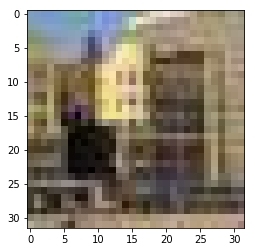

In [25]:
plt.imshow(real_examples[0].data.cpu().numpy().transpose(1, 2, 0))

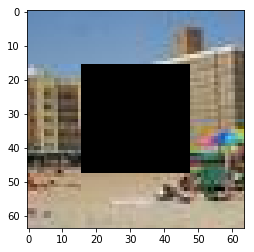

In [28]:
plt.imshow(fake_images[0].data.cpu().numpy().transpose(1, 2, 0))

In [29]:
x = np.random.rand(10, 3, 64, 64)
y = np